Epoch 1/10, Loss: 0.0280
Epoch 2/10, Loss: 0.0064
Epoch 3/10, Loss: 0.0053
Epoch 4/10, Loss: 0.0052
Epoch 5/10, Loss: 0.0047
Epoch 6/10, Loss: 0.0037
Epoch 7/10, Loss: 0.0038
Epoch 8/10, Loss: 0.0030
Epoch 9/10, Loss: 0.0032
Epoch 10/10, Loss: 0.0026
✅ Training Complete!


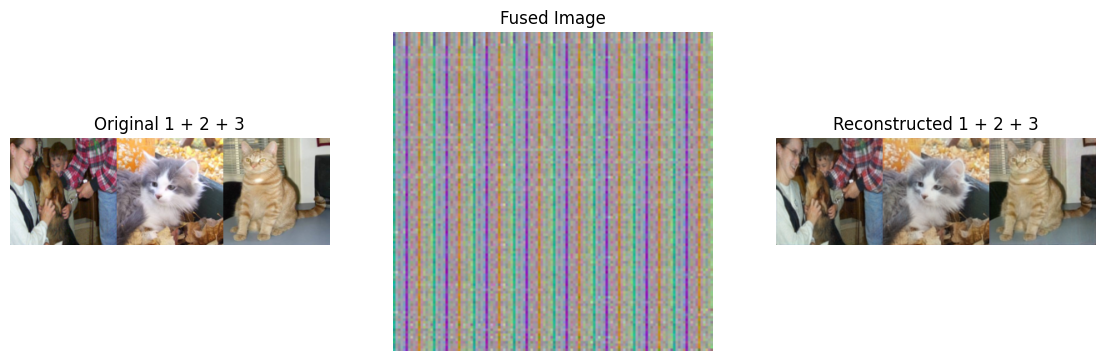

✅ Encoder and Decoder (3-image version) models saved successfully!


In [1]:
# =======================
# 1. Imports
# =======================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

# =======================
# 2. Encoder-Decoder Models
# =======================
class Encoder(nn.Module):
    def __init__(self, latent_channels=16):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(9, 64, 3, padding=1),   # 3 images × 3 channels = 9
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, latent_channels, 3, padding=1)
        )

    def forward(self, img1, img2, img3):
        x = torch.cat([img1, img2, img3], dim=1)
        return self.conv(x)


class Decoder(nn.Module):
    def __init__(self, latent_channels=16):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(latent_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 9, 3, padding=1)  # 3 reconstructed RGB images = 9 channels
        )

    def forward(self, fusion):
        x = self.conv(fusion)
        recon1, recon2, recon3 = torch.chunk(x, 3, dim=1)
        return recon1, recon2, recon3


# =======================
# 3. Dataset
# =======================
class TripleImageDataset(Dataset):
    def __init__(self, folder1, folder2, folder3, transform=None):
        self.folder1 = folder1
        self.folder2 = folder2
        self.folder3 = folder3
        self.transform = transform
        self.files1 = sorted(os.listdir(folder1))
        self.files2 = sorted(os.listdir(folder2))
        self.files3 = sorted(os.listdir(folder3))
        assert len(self.files1) == len(self.files2) == len(self.files3), "All folders must have same number of images"

    def __len__(self):
        return len(self.files1)

    def __getitem__(self, idx):
        img1 = Image.open(os.path.join(self.folder1, self.files1[idx])).convert('RGB')
        img2 = Image.open(os.path.join(self.folder2, self.files2[idx])).convert('RGB')
        img3 = Image.open(os.path.join(self.folder3, self.files3[idx])).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return img1, img2, img3


# =======================
# 4. Utils
# =======================
def tensor_to_pil(tensor):
    img = tensor.detach().cpu()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img = (img * 255).byte()
    img = img.permute(1, 2, 0).numpy()
    return Image.fromarray(img, mode="RGB")


# =======================
# 5. Paths & Transforms
# =======================
img1_folder = 'D:/Research and Design Simulation/fusion_env/Include/data/img1'
img2_folder = 'D:/Research and Design Simulation/fusion_env/Include/data/img2'
img3_folder = 'D:/Research and Design Simulation/fusion_env/Include/data/img3'
fusion_folder = 'D:/Research and Design Simulation/fusion_env/Include/data/fused'
os.makedirs(fusion_folder, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = TripleImageDataset(img1_folder, img2_folder, img3_folder, transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =======================
# 6. Models, Optimizer, Loss
# =======================
latent_channels = 16
encoder = Encoder(latent_channels).to(device)
decoder = Decoder(latent_channels).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
criterion = nn.MSELoss()

# =======================
# 7. Training Loop
# =======================
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for img1, img2, img3 in dataloader:
        img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)

        optimizer.zero_grad()
        fusion = encoder(img1, img2, img3)
        recon1, recon2, recon3 = decoder(fusion)

        loss = criterion(recon1, img1) + criterion(recon2, img2) + criterion(recon3, img3)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Save fused image example
        fused_img = tensor_to_pil(fusion[0])
        fused_img.save(os.path.join(fusion_folder, f'fused_epoch{epoch}.png'))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")

print("✅ Training Complete!")


# =======================
# 8. Test Reconstruction
# =======================
encoder.eval()
decoder.eval()
with torch.no_grad():
    img1, img2, img3 = next(iter(dataloader))
    img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
    fusion = encoder(img1, img2, img3)
    recon1, recon2, recon3 = decoder(fusion)

    # Show Original 3 → Fused → Reconstructed 3
    plt.figure(figsize=(14, 6))

    # Originals
    originals = torch.cat([img1[0], img2[0], img3[0]], dim=2)
    plt.subplot(1, 3, 1)
    plt.title("Original 1 + 2 + 3")
    plt.imshow(tensor_to_pil(originals))
    plt.axis('off')

    # Fused
    plt.subplot(1, 3, 2)
    plt.title("Fused Image")
    plt.imshow(tensor_to_pil(fusion[0]))
    plt.axis('off')

    # Reconstructed
    recons = torch.cat([recon1[0], recon2[0], recon3[0]], dim=2)
    plt.subplot(1, 3, 3)
    plt.title("Reconstructed 1 + 2 + 3")
    plt.imshow(tensor_to_pil(recons))
    plt.axis('off')

    plt.show()


# =======================
# 9. Save Trained Models
# =======================
save_path = "D:/Research and Design Simulation/fusion_env/Include/models"
os.makedirs(save_path, exist_ok=True)

torch.save(encoder.state_dict(), os.path.join(save_path, "encoder_3img.pth"))
torch.save(decoder.state_dict(), os.path.join(save_path, "decoder_3img.pth"))

print("✅ Encoder and Decoder (3-image version) models saved successfully!")


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os

# =======================
# 1. Encoder-Decoder Models (3 inputs)
# =======================
class Encoder(nn.Module):
    def __init__(self, latent_channels=16):
        super().__init__()
        # 3 images × 3 channels = 9 channels
        self.conv = nn.Sequential(
            nn.Conv2d(9, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, latent_channels, 3, padding=1)
        )

    def forward(self, img1, img2, img3):
        x = torch.cat([img1, img2, img3], dim=1)
        return self.conv(x)


class Decoder(nn.Module):
    def __init__(self, latent_channels=16):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(latent_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            # Output 9 channels → 3 reconstructions (3×3)
            nn.Conv2d(64, 9, 3, padding=1)
        )

    def forward(self, fusion):
        x = self.conv(fusion)
        recon1, recon2, recon3 = torch.split(x, 3, dim=1)
        return recon1, recon2, recon3


# =======================
# 2. Dataset (3 folders)
# =======================
class ImageTripletDataset(torch.utils.data.Dataset):
    def __init__(self, folder1, folder2, folder3, transform=None):
        self.folder1 = folder1
        self.folder2 = folder2
        self.folder3 = folder3
        self.files1 = sorted(os.listdir(folder1))
        self.files2 = sorted(os.listdir(folder2))
        self.files3 = sorted(os.listdir(folder3))
        self.transform = transform

    def __len__(self):
        return min(len(self.files1), len(self.files2), len(self.files3))

    def __getitem__(self, idx):
        img1_path = os.path.join(self.folder1, self.files1[idx])
        img2_path = os.path.join(self.folder2, self.files2[idx])
        img3_path = os.path.join(self.folder3, self.files3[idx])

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        img3 = Image.open(img3_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return img1, img2, img3


# =======================
# 3. Helper: Tensor → PIL
# =======================
def tensor_to_pil(tensor):
    img = tensor.detach().cpu()
    if img.dim() == 3:
        img = img[:3, :, :]
        img = img.permute(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = (img * 255).byte().numpy()
        return Image.fromarray(img, mode="RGB")
    else:
        raise ValueError(f"Unexpected tensor shape: {img.shape}")


# =======================
# 4. Load Models
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)

encoder.load_state_dict(torch.load(
    r"D:\Research and Design Simulation\fusion_env\Include\models\encoder_3img.pth",
    map_location=device
))
decoder.load_state_dict(torch.load(
    r"D:\Research and Design Simulation\fusion_env\Include\models\decoder_3img.pth",
    map_location=device
))

encoder.eval()
decoder.eval()


# =======================
# 5. Test Dataset & Loader
# =======================
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test_dataset = ImageTripletDataset(
    r"D:\Research and Design Simulation\fusion_env\Include\data\test\img1",
    r"D:\Research and Design Simulation\fusion_env\Include\data\test\img2",
    r"D:\Research and Design Simulation\fusion_env\Include\data\test\img3",
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# =======================
# 6. Run Test
# =======================
save_dir = "test_results_3img"
os.makedirs(save_dir, exist_ok=True)

with torch.no_grad():
    for i, (img1, img2, img3) in enumerate(test_loader):
        img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)

        # Encode & Fuse
        fused = encoder(img1, img2, img3)

        # Decode
        recon1, recon2, recon3 = decoder(fused)

        # Save results
        tensor_to_pil(img1[0]).save(f"{save_dir}/test_{i}_input1.png")
        tensor_to_pil(img2[0]).save(f"{save_dir}/test_{i}_input2.png")
        tensor_to_pil(img3[0]).save(f"{save_dir}/test_{i}_input3.png")
        tensor_to_pil(fused[0]).save(f"{save_dir}/test_{i}_fused.png")
        tensor_to_pil(recon1[0]).save(f"{save_dir}/test_{i}_recon1.png")
        tensor_to_pil(recon2[0]).save(f"{save_dir}/test_{i}_recon2.png")
        tensor_to_pil(recon3[0]).save(f"{save_dir}/test_{i}_recon3.png")

print("✅ 3-Image Testing complete! Check the 'test_results_3img' folder.")


✅ 3-Image Testing complete! Check the 'test_results_3img' folder.


In [1]:
from PIL import Image

# Example
img1 = Image.open("D:/Research and Design Simulation/fusion_env/Include/data/img1/dog.1.jpg")
fused = Image.open("D:/Research and Design Simulation/fusion_env/Include/data/fused/fused_0_0.png")

print("Original 1 size:", img1.size)   # (width, height)
print("Fused 1 size:", fused.size)     # (width, height)


Original 1 size: (327, 499)
Fused 1 size: (128, 128)
